# Test statistics

In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
num_ind = 30
num_cell_per_ind = 1000
beta_geno = 1
beta_age = 0
ind_intercepts = stats.norm.rvs(scale=2, size=num_ind) * 0
intercept = 10
geno = np.array([0 for i in range(int(num_ind/3))] + [1 for i in range(int(num_ind/3))] + [2 for i in range(int(num_ind/3))])
age = stats.norm.rvs(scale=10, loc=30, size=num_ind)

In [3]:
data = []
for ind in range(num_ind):
    mu = intercept+beta_geno*geno[ind]+beta_age*age[ind]+ind_intercepts[ind]
    data.append(stats.norm.rvs(loc=mu, scale=1, size=num_cell_per_ind))

df = pd.DataFrame()
df['expr'] = np.concatenate(data)
df['geno'] = np.repeat(geno, num_cell_per_ind)
df['age'] = np.repeat(age, num_cell_per_ind)
df['ind'] = ['donor_' + str(x) for x in np.repeat(range(num_ind), num_cell_per_ind)]
dummy_df = pd.get_dummies(df, drop_first=True)

In [51]:
def m(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def corr(x, y, w):
    """Weighted Correlation"""
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

In [50]:
stats.pearsonr(df['expr'], df['geno'])

(0.6336992804422077, 0.0)

In [52]:
corr(weighted_df['geno'], weighted_df['mean'], weighted_df['count'])

0.9998394998293151

In [ ]:
stats.pearsonr(weighted_df['mean'], weighted_df[''])

In [46]:
smf.ols("expr ~ geno", df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   expr   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 2.013e+04
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:26:57   Log-Likelihood:                -42506.
No. Observations:               30000   AIC:                         8.502e+04
Df Residuals:                   29998   BIC:                         8.503e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.9927      0.009   1096.873      0.000       9.975      10.011
geno           1.0012      0.007    141.881      0.000       0.987       1.015
==============================================================================
Omnibus:                        0.296   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.863   Jarque-Bera (JB):                0.298
Skew:                          -0.008   Prob(JB):                        0.862
Kurtosis:                       2.998   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
weighted_df = df.groupby('geno').agg({'expr':['mean', 'count']})
weighted_df.columns = weighted_df.columns.get_level_values(1)
weighted_df = weighted_df.reset_index()

In [48]:
weighted_df

,geno,mean,count
0,0,10.003071,10000
1,1,10.973211,10000
2,2,12.005499,10000


In [49]:
sm.WLS(weighted_df['mean'], sm.add_constant(weighted_df[['geno']]), weights=weighted_df['count']).fit().summary()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   mean   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3115.
Date:                Tue, 08 Mar 2022   Prob (F-statistic):             0.0114
Time:                        16:27:00   Log-Likelihood:                 8.4135
No. Observations:                   3   AIC:                            -12.83
Df Residuals:                       1   BIC:                            -14.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9927      0.023    431.446      0.001       9.698      10.287
geno           1.0012      0.018     55.808      0.011       0.773       1.229
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   3.000
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.531
Skew:                          -0.707   Prob(JB):                        0.767
Kurtosis:                       1.500   Cond. No.                         2.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Smooth bootstrap

In [53]:
mu = 0.1
alpha = 3
var = mu + alpha * mu**2
N=1000
def convert_params(mu, alpha):
    """ 
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    Parameters
    ----------
    mu : float 
       Mean of NB distribution.
    alpha : float
       Overdispersion parameter used for variance calculation.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    var = mu + alpha * mu ** 2
    p = mu / var
    r = mu ** 2 / (var - mu)
    return r, p

In [54]:
sample = stats.nbinom.rvs(*convert_params(mu, alpha), size=N)
num_iter = 10000
sampling_dist = np.zeros(num_iter)

(array([918.,   0.,  65.,   0.,   0.,  16.,   0.,   0.,   0.,   1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

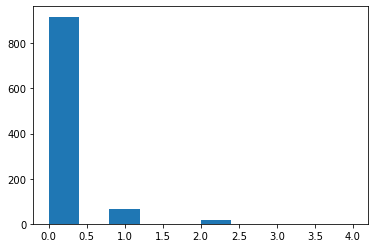

In [55]:
plt.hist(sample)

In [56]:
for itr in range(num_iter):
    sampling_dist[itr] = np.log(stats.nbinom.rvs(*convert_params(mu, alpha), size=N).var())

In [57]:
# sample[-1] = 500
print(sample.max())
sample[-3] = 8


4


In [58]:
params = sm.NegativeBinomial(sample, np.ones((N, 1))).fit().params
mu_hat = np.exp(params[0])
alpha_hat = params[1]

Optimization terminated successfully.
         Current function value: 0.344960
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


In [59]:
1/N/10

0.0001

In [60]:
np.sort(stats.nbinom.pmf(sample, *convert_params(mu_hat, alpha_hat)))[:5]

array([1.04193743e-05, 1.05170678e-03, 1.37639382e-02, 1.37639382e-02,
       1.37639382e-02])

In [39]:
boot_para_dist = np.zeros(num_iter)
boot_dist = np.zeros(num_iter)
# fit = stats.nbinom.fit(sample)
for boot in range(num_iter):
    boot_dist[boot] = np.log((np.random.choice(sample, N)).var())
    x = stats.nbinom.rvs(*convert_params(mu_hat, alpha_hat), size=N)
    boot_para_dist[boot] = np.log(x.var())

In [40]:
print(np.std(sampling_dist))
print(np.std(boot_dist))
print(np.std(boot_para_dist))

0.16826519016684052
0.42206678547259724
0.21209583026658912


In [41]:
np.log(var)

-2.0402208285265546

<AxesSubplot:ylabel='Density'>

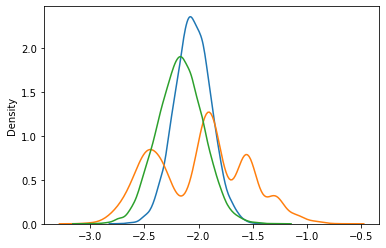

In [42]:
sns.kdeplot(sampling_dist)
sns.kdeplot(boot_dist)
sns.kdeplot(boot_para_dist)

# plt.plot([np.log(var), np.log(var)], [0, 5])